### Based on `quantify_blobs.ipynb`, check if the blobs have these weird, short tails in the pre-beersheba stuff

In [1]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


import os
import sys
import random
import tables as tb
import numpy  as np
import pandas as pd
import scipy.spatial.distance as scidist
import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.core.stat_functions import poisson_sigma
import invisible_cities.reco.dst_functions  as dstf
from   invisible_cities.core.core_functions import shift_to_bin_centers
from invisible_cities.core.testing_utils import assert_hit_equality
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy
# hack to avoid QhullError
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError
from  skimage.morphology import skeletonize_3d

from invisible_cities.evm                  import event_model as evm
from invisible_cities.evm  .event_model    import Cluster, Hit
from invisible_cities.types.ic_types       import xy
from invisible_cities.reco import paolina_functions    as plf

from invisible_cities.io.dst_io import load_dst
import invisible_cities.io.mcinfo_io as mcio

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patheffects as PathEffects
import matplotlib.lines as mlines


import core.functions as func

import imageio


#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [2]:


def add_binclass(mchits, mcpart, signal_creator = 'conv'):
    '''
    Adds binary class to each hit depending on if its event is considered as signal or background.
    The two possible classes for the events are:
        0 - background
        1 - signal
    Process:
        - Selects particles that had any hit in the active.
        - Selects only e-/e+
        - If there are 2 particles in an event that are created by a certain process,
          labels the event as signal. 
        - Otherwise, as background.
    For double escape data, the creator process is signal_creator = 'conv' (i.e. 208Tl data).
    For 0nubb data, the creator process is signal_creator = 'none'.

    Args:
        mchits: DATAFRAME
    Contains the MC hits information of every event in a file, from table MC/hits.
        mcpart: DATAFRAME
    Contains the MC particles information for every event in a file, from table MC/particles.
        signal_creator: STR
    If 'conv', signal will be the double escape data.
    If 'none', signal will be the neutrinoless decay data.
    
    RETURNS:
        mchits_binclass: DATAFRAME
    The mchits df with a new column containing the binclass.
    '''

    # Select only those particles that actually left any hit in the active
    hits_part = pd.merge(mchits, mcpart, on = ['event_id', 'particle_id'])
    hits_part = hits_part[mcpart.columns].drop_duplicates()

    # Select e+/e-
    hits_part = hits_part[np.isin(hits_part.particle_name, ['e+', 'e-'])]
    
    # Create a selector of signal/background
    selector = lambda x: 1 if int(sum(x == signal_creator)) == 2 else 0

    class_label = hits_part.groupby('event_id').creator_proc.apply(selector).astype(int)
    class_label.name = 'binclass'
    mchits_binclass  = pd.merge(mchits, class_label, on = 'event_id')
    
    return mchits_binclass

def get_extremes(file, signal_creator = 'conv'):
    '''
    Gets the extremes of the MC track. 
    It also gives them a label, called 'ext', which can be:
        1 - end   of background track, random for signal track
        2 - start of background track, random for signal track (for similarity with 'blob2')
    Process:
        - Do binary classification of the events
        - Select the main particles in the event (e+e- or e-e- for signal,
          the most energetic e- for background)
        - Select the extremes (last hits for signal, first/last for background)
    
    Args:
        file: STR
    Path to any file with MC information.
        signal_creator: STR
    If 'conv', signal will be the double scape data.
    If 'none', signal will be the neutrinoless decay data.
    
    RETURNS:
        track_ext: DATAFRAME
    The extreme hits of each event with a label.
    '''

    mcpart = load_dst(file, 'MC', 'particles')
    mchits = load_dst(file, 'MC', 'hits')
    mchits = mchits[mchits.label == 'ACTIVE']
    
    # Add binclass label to the hits
    mchits_label = add_binclass(mchits, mcpart, signal_creator = signal_creator)
    # Add to each hit the particle information
    hits_part = pd.merge(mchits_label, mcpart, on = ['event_id', 'particle_id'])
    # Do the sum on the energy so we can choose the most energetic e- in a bkg event
    per_part_info = hits_part.groupby(['event_id',
                                        'particle_id',
                                        'particle_name',
                                        'binclass',
                                        'creator_proc']).agg({'energy':[('track_ener', sum)], 'hit_id':[('nhits', len)]})
    per_part_info.columns = per_part_info.columns.get_level_values(1)
    per_part_info.reset_index(inplace=True)

    # Select each type of particle
    ## Signal
    particles_sig = per_part_info[(per_part_info.binclass == 1) &\
                                    np.isin(per_part_info.particle_name, ['e+', 'e-']) &\
                                    (per_part_info.creator_proc == signal_creator)]
    ## Background
    particles_bkg = per_part_info[(per_part_info.binclass == 0) &\
                                    (per_part_info.particle_name == 'e-') &\
                                    (per_part_info.creator_proc.isin(['compt', 'phot', 'none']))]

    particles_bkg = particles_bkg.loc[particles_bkg.groupby('event_id').track_ener.idxmax()]

    # Search for the extremes
    ## Signal
    hits_sig = pd.merge(mchits_label, particles_sig)
    track_ext_sig = hits_sig.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()]).reset_index(drop = True)
    track_ext_sig['ext'] = track_ext_sig.groupby('event_id').cumcount() + 1

    ## Background
    hits_bkg = pd.merge(mchits_label, particles_bkg)

    track_start_bkg = hits_bkg.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmin()]).reset_index(drop=True)
    track_end_bkg   = hits_bkg.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()]).reset_index(drop=True)

    ### asigned this label so 2 is like "blob2" 
    track_start_bkg['ext'] = 2
    track_end_bkg['ext']   = 1

    # Join all
    track_ext_bkg = pd.concat([track_start_bkg, track_end_bkg])
    track_ext = pd.concat([track_ext_bkg, track_ext_sig]).sort_values('event_id')
    return track_ext


In [3]:
path = 'data/'
tracking = pd.read_hdf(path + 'isaura_1_208Tl.h5', 'Tracking/Tracks')
df = pd.read_hdf(path + 'beersheba_1_208Tl.h5', 'DECO/Events')
events = np.unique(df.event.to_numpy())

# also load in MC
dfMC = mcio.load_mchits_df(path + 'isaura_1_208Tl.h5').reset_index()
eventsMC = np.unique(dfMC.event_id.to_numpy())
infoMC = pd.read_hdf(path + 'isaura_1_208Tl.h5', 'MC/particles')

## MC extremes from Martins code
mc_extr = get_extremes(path + 'isaura_1_208Tl.h5')

## load in sophronia
reco = pd.read_hdf(path + 'sophronia_1_208Tl.h5', 'RECO/Events')

In [4]:
evt_num = 506

df_evt = df[df.event == evt_num]
reco_evt = reco[reco.event == evt_num]

display(df_evt)
display(reco_evt)


dataMC = dfMC[dfMC.event_id == evt_num//2]
display(dataMC)

,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
2197052,506,0.0,-2.125,-100.425,352.818277,0.000022,-41.528932,-210.655274,5.072264e+08,0,0,0
2197053,506,0.0,-2.125,-99.425,352.818277,0.000025,-41.528932,-210.655274,5.072264e+08,0,0,0
2197054,506,0.0,-2.125,-98.425,352.818277,0.000022,-41.528932,-210.655274,5.072264e+08,0,0,0
2197055,506,0.0,-1.125,-101.425,352.818277,0.000023,-41.528932,-210.655274,5.072264e+08,0,0,0
2197056,506,0.0,-1.125,-100.425,352.818277,0.000037,-41.528932,-210.655274,5.072264e+08,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2219003,506,0.0,-42.125,-238.425,584.968584,0.000028,-41.528932,-210.655274,5.072264e+08,0,0,0
2219004,506,0.0,-41.125,-242.425,584.968584,0.000026,-41.528932,-210.655274,5.072264e+08,0,0,0
2219005,506,0.0,-41.125,-241.425,584.968584,0.000035,-41.528932,-210.655274,5.072264e+08,0,0,0
2219006,506,0.0,-41.125,-240.425,584.968584,0.000036,-41.528932,-210.655274,5.072264e+08,0,0,0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
605115,506,5.072264e+08,0,-41.528932,-210.655274,1,-85.525,-380.975,0.0,0.0,348.197479,1.043478,0.428571,-1.0,1.442566e-06,-1,-1.0
605116,506,5.072264e+08,0,-41.528932,-210.655274,1,-7.775,-412.075,0.0,0.0,348.197479,1.855072,0.761905,-1.0,2.611750e-06,-1,-1.0
605117,506,5.072264e+08,0,-41.528932,-210.655274,1,-7.775,-272.125,0.0,0.0,348.197479,1.043478,0.428571,-1.0,1.364479e-06,-1,-1.0
605118,506,5.072264e+08,0,-41.528932,-210.655274,1,-38.875,-209.925,0.0,0.0,348.197479,1.565217,0.642857,-1.0,1.996232e-06,-1,-1.0
605119,506,5.072264e+08,0,-41.528932,-210.655274,1,272.125,-349.875,0.0,0.0,348.197479,1.797101,0.738095,-1.0,2.658786e-06,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615530,506,5.072264e+08,0,-41.528932,-210.655274,1,-101.075,241.025,0.0,0.0,591.228699,1.681159,0.142857,-1.0,4.680258e-07,-1,-1.0
615531,506,5.072264e+08,0,-41.528932,-210.655274,1,38.875,-272.125,0.0,0.0,591.228699,1.217391,0.103448,-1.0,3.346682e-07,-1,-1.0
615532,506,5.072264e+08,0,-41.528932,-210.655274,1,225.475,-163.275,0.0,0.0,591.228699,1.217391,0.103448,-1.0,3.363250e-07,-1,-1.0
615533,506,5.072264e+08,0,-41.528932,-210.655274,1,132.175,23.325,0.0,0.0,591.228699,1.507246,0.128079,-1.0,4.054845e-07,-1,-1.0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
89876,253,17,0,46.997559,-43.403534,409.431580,1.923671,0.000023,ACTIVE
89877,253,19,0,46.997440,-43.403343,409.431610,1.923727,0.000047,ACTIVE
89878,253,18,0,46.488457,-44.192432,409.087708,1.927066,0.002149,ACTIVE
89879,253,18,1,45.986183,-44.977722,408.726044,1.930460,0.003242,ACTIVE
89880,253,18,2,45.417503,-45.663223,408.288208,1.933830,0.001276,ACTIVE
...,...,...,...,...,...,...,...,...,...
90777,253,28,6,34.844627,-55.017017,391.677887,2.012990,0.000931,ACTIVE
90778,253,28,7,34.853737,-55.007969,391.681702,2.013269,0.001796,ACTIVE
90779,253,28,8,34.848251,-55.004601,391.675964,2.013479,0.001653,ACTIVE
90780,253,28,9,34.845684,-55.004654,391.671875,2.013623,0.001899,ACTIVE


Text(0.5, 0.98, '3D_deconvolved_plot_506')

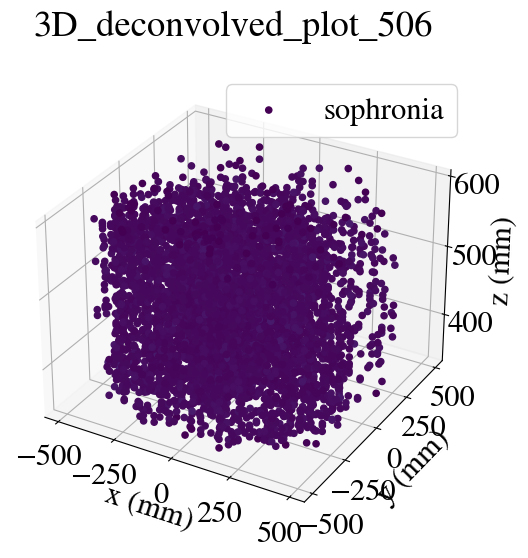

In [5]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d')





x = reco_evt.X
y = reco_evt.Y
z = reco_evt.Z
e = reco_evt.E

xdf = df_evt.X
ydf = df_evt.Y
zdf = df_evt.Z
edf = df_evt.E


p = ax.scatter3D(x, y, z, c=e, alpha=1, cmap='viridis', zorder=1, label = 'sophronia')
#q = ax.scatter3D(xdf, ydf, zdf, c=edf, alpha=1, cmap='Accent', zorder=1, label = 'deco')

plt.legend()


ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

#ax.view_init(20, 270)


# blob parts

fig.suptitle('3D_deconvolved_plot_' + str(evt_num))

### apply the cuts to the sophronia data to clean it up

Using a very messy sophronia input it looks like

In [6]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
#file = f'../../../Tl_studies/LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_180_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = 'localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
thresh = 4
pes = 1
threshold = thresh * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'/home/e78368jw/Documents/NEXT_CODE/Tl_studies/LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = thresh,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 5e-5,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 75,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  satellite_iter  = 5,
                  satellite_dist  = 2,
                  satellite_size  = 30,
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1.440, 1.440),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  




#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

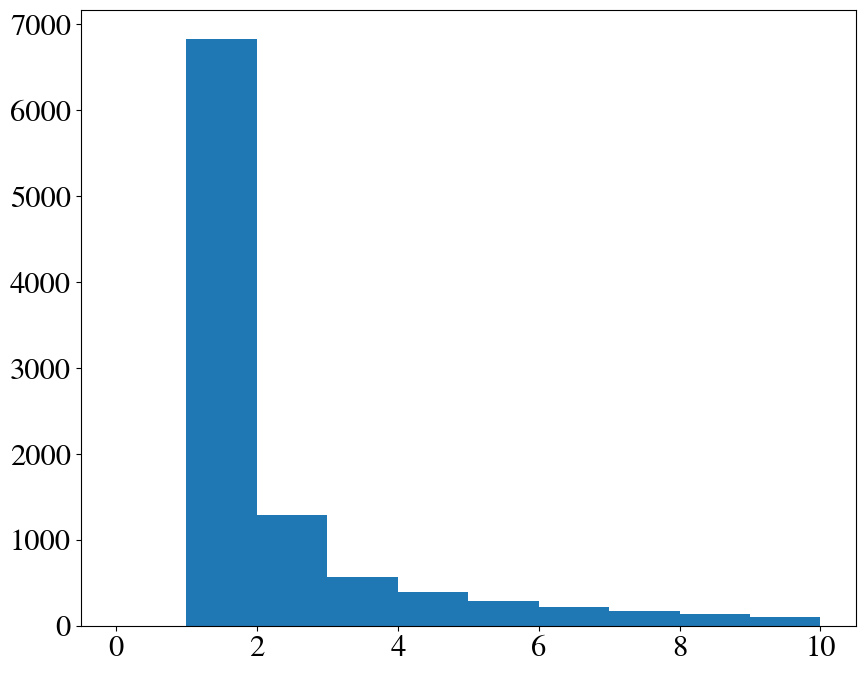

Time spent in cut_over_Q: 0.01288294792175293 s


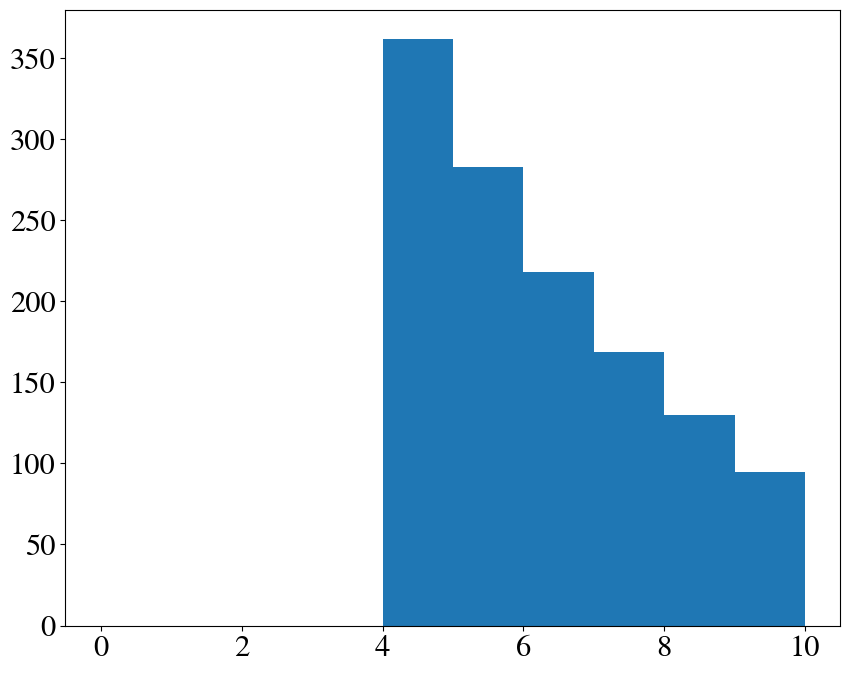

In [7]:
# check, what the q_threshold for sophronia?

plt.hist(reco_evt.Q.to_numpy(), range=(0,10))
plt.show()
# need to apply cut
hits_cut = coref.timefunc(cut_sensors)(reco_evt.copy())
plt.hist(hits_cut.Q.to_numpy(), range=(0,10))
plt.show()

In [8]:
# drop isolated sensors
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.04405069351196289 s


Text(0.5, 0.98, '3D_deconvolved_plot_cut_506')

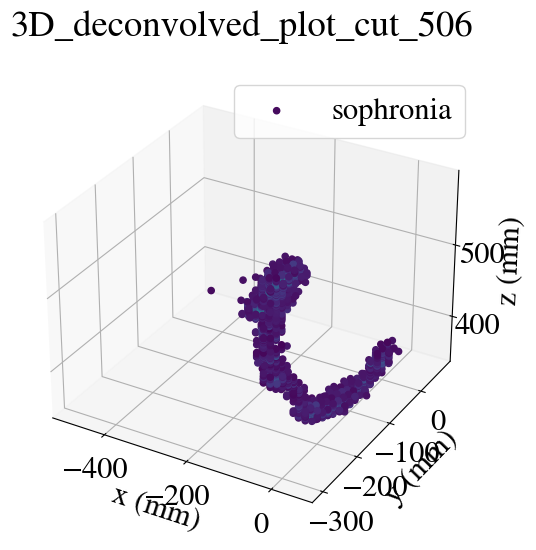

In [9]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d')





x = hits_cut.X
y = hits_cut.Y
z = hits_cut.Z
e = hits_cut.E

xdf = df_evt.X
ydf = df_evt.Y
zdf = df_evt.Z
edf = df_evt.E


p = ax.scatter3D(x, y, z, c=e, alpha=1, cmap='viridis', zorder=1, label = 'sophronia')
#q = ax.scatter3D(xdf, ydf, zdf, c=edf, alpha=1, cmap='Accent', zorder=1, label = 'deco')

plt.legend()


ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

#ax.view_init(20, 270)


# blob parts

fig.suptitle('3D_deconvolved_plot_cut_' + str(evt_num))

Text(0.5, 0.98, '3D_deconvolved_plot_drop_506')

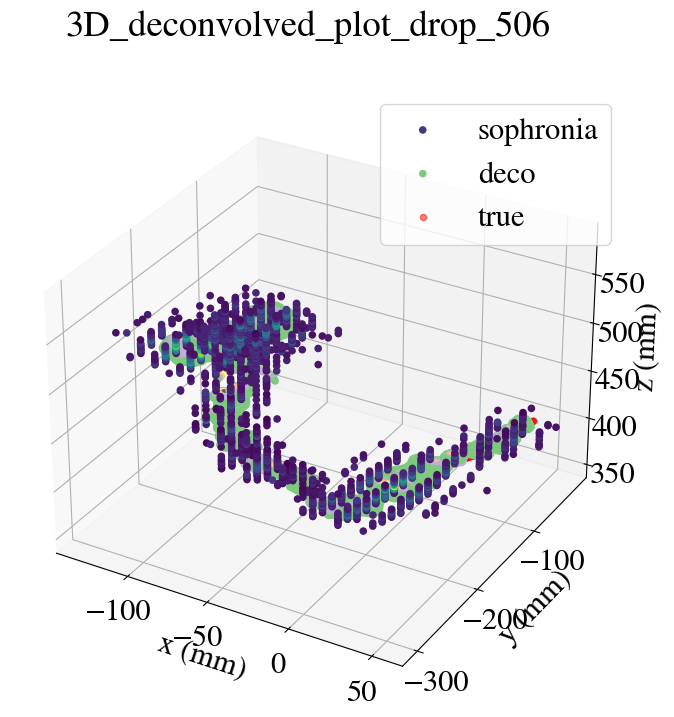

In [10]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')





x = hits_drop.X
y = hits_drop.Y
z = hits_drop.Z
e = hits_drop.E

xdf = df_evt.X
ydf = df_evt.Y
zdf = df_evt.Z
edf = df_evt.E

xt = dataMC.x
yt = dataMC.y
zt = dataMC.z
et = dataMC.energy*1000



p = ax.scatter3D(x, y, z, c=e, alpha=1, cmap='viridis', zorder=1, label = 'sophronia')
q = ax.scatter3D(xdf, ydf, zdf, c=edf, alpha=1, cmap='Accent', zorder=1, label = 'deco')

q = ax.scatter3D(xt, yt, zt, alpha = 0.5, color = 'red', zorder = 0, label = 'true')

plt.legend()


ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

#ax.view_init(20, 270)


# blob parts

fig.suptitle('3D_deconvolved_plot_drop_' + str(evt_num))

### SPIN

In [11]:
rotation = True
evt = evt_num


if rotation==True:
  rotation_space = np.linspace(0, 359, 30, endpoint = True)

  for i in (rotation_space):
    fig = plt.figure()
    fig.suptitle('3D post deconvolution ' + str(evt_num), fontsize=20)
    ax = fig.add_subplot(111, projection='3d')
    #em = e > 0.00005 # eliminate small things for measurement
    #p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
    p = ax.scatter(x, y, z, c=e, alpha=1, cmap='viridis')
    q = ax.scatter3D(xdf, ydf, zdf, c=edf, alpha=1, cmap='Accent', zorder=1, label = 'deco')
    r = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')

    # overlay the blobs and their radii

    cb = fig.colorbar(p, ax=ax)
    cb.set_label('Energy (keV)')

    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_zlabel('z (mm)')
    ax.view_init(20, -i)
    plt.savefig(f'gif_making/deconv/angle_{i}.png')
    plt.close(fig)

In [13]:
if rotation == True:
    
    files = [f for f in os.listdir('gif_making/deconv/') if os.path.isfile(os.path.join('gif_making/deconv/', f))]

    #sort files in a human manner
    files.sort(key=func.alphanum_key)
    images = []
    for filename in files:
        images.append(imageio.imread('gif_making/deconv/' + filename))
    

    print("Creating gif...")
    gif_name = f'gif_making/output/rotating_track_blob_pos_evt_{evt}.gif'
    imageio.mimsave(gif_name, images, loop = 0, fps = 3)

/tmp/ipykernel_80912/3339802900.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('gif_making/deconv/' + filename))


Creating gif...


<img src=gif_making/output/rotating_track_blob_pos_evt_506.gif width="750" align="center">

### ENHANCE

Text(0.5, 0.98, '3D_deconvolved_plot_drop_506')

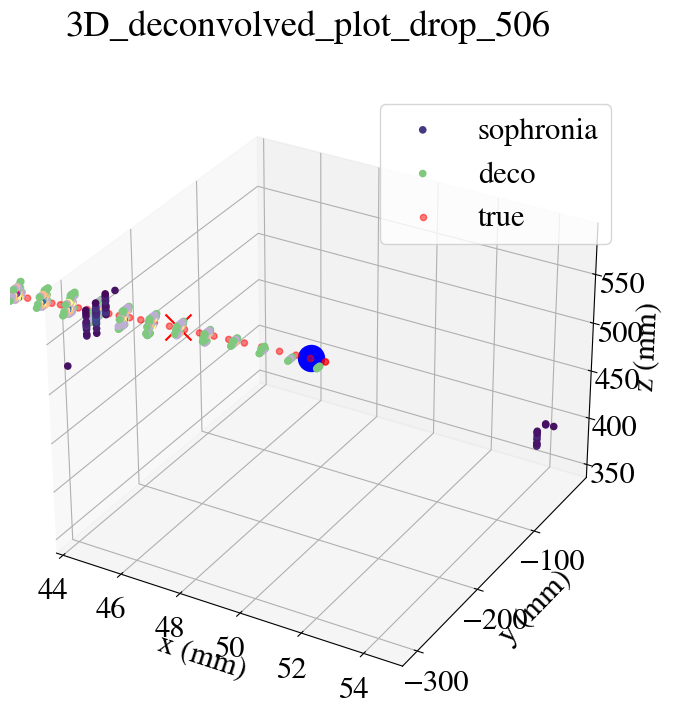

In [30]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')





x = hits_drop.X
y = hits_drop.Y
z = hits_drop.Z
e = hits_drop.E

xdf = df_evt.X
ydf = df_evt.Y
zdf = df_evt.Z
edf = df_evt.E

xt = dataMC.x
yt = dataMC.y
zt = dataMC.z
et = dataMC.energy*1000



p = ax.scatter3D(x, y, z, c=e, alpha=1, cmap='viridis', zorder=1, label = 'sophronia')
q = ax.scatter3D(xdf, ydf, zdf, c=edf, alpha=1, cmap='Accent', zorder=1, label = 'deco')

q = ax.scatter3D(xt, yt, zt, alpha = 0.5, color = 'red', zorder = 0, label = 'true')

plt.legend()


ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

#ax.view_init(220, 180)
ax.scatter3D(41.791720121583346, -48.045529003683015, 404.90548769556483, s = 350, c = 'red', marker = 'x', zorder = 100, label = 'predicted blob2', depthshade=False)
ax.scatter3D(46.488457,	-44.192432,	409.087708, s = 350, c = 'blue', marker = 'o', zorder = 100, label = 'true blob2', depthshade=False)

ax.set_xlim([44, 55])
# blob parts

fig.suptitle('3D_deconvolved_plot_drop_' + str(evt_num))

In [36]:
# magnitude of this being off
a = np.array([46.488457, -44.192432, 409.087708])
b = np.array([41.791720121583346, -48.045529003683015, 404.90548769556483])

mag = np.linalg.norm(a-b)
print(mag)


7.375409175069544
